# Electricity Demands

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.preprocessing import PowerTransformer, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as sklearnPipeline
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix
from sklearn.semi_supervised import LabelPropagation

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier

# Functions

In [23]:
def check_for_nulls_dupes(df):
  print(f"The amount of Null Values: {df.isna().sum()}")
  print(f"The amount of Duplicated Values {df.duplicated().sum()}")

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()

def create_column_transformer(cat_cols, numeric_cols):
  
  cat_transformer = Pipeline(
    steps=[
      ("encoder", OneHotEncoder())
    ]
  )
  
  numeric_transformer = Pipeline(
    steps =[
      ("scaler", RobustScaler()),
      ("PowerTransformer", PowerTransformer())
    ]
  )
  
  return ColumnTransformer(
    transformers=[
      ("cat", cat_transformer, cat_cols),
      ("numeric", numeric_transformer, numeric_cols)
    ]
  )

def create_sklearn_pipeline(preprocessor,model, kbest=None):
  
  steps = [
    ("preprocessor", preprocessor),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(1, ("Feature Selection", kbest))
  
  return sklearnPipeline(steps=steps)

def create_sampling_pipeline(preprocessor, sampling_model, model, kbest=None):
  
  steps = [
    ("preprocessor", preprocessor),
    ("sample", sampling_model),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(2, ("Feature Selection", kbest))
  
  return Pipeline(steps=steps)

def plot_distribution(df, kind):
  
  plt.figure(figsize=(16,16))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(df.columns):
    if col == "Type":
      continue
    plt.subplot(rows ,4, idx+1)
    sns.histplot(df[col], kde=True) if kind == "hist" else plt.boxplot(df[col])
    plt.title(f"Distribuition of {col}")
    plt.ylabel("Counts")

  plt.tight_layout()
  plt.show()

def dist_plot(df):
  
  for col in df.columns:
    salary_skewness = df[col].skew()
    salary_kurtosis = df[col].kurtosis()

    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True, color='blue')
    plt.title(f'Distribution of {col} with Skewness and Kurtosis')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    plt.text(x=0.95, y=0.85, s=f"Skewness: {salary_skewness:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')
    plt.text(x=0.95, y=0.80, s=f"Kurtosis: {salary_kurtosis:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')

    plt.grid(True)
    plt.show()

def aggregate_dataset(df, interested_columns, agg_col, function):
  
  plt.figure(figsize=(12,12))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == agg_col:
      continue
    plt.subplot(rows ,4, idx+1)
    grouped_df = getattr(df.groupby(agg_col)[col], function)().reset_index(name=col)
    sns.barplot(data=grouped_df, x=agg_col, y=col)
    plt.title(f"Agg of {col}")
    plt.ylabel(col)
    plt.xticks(rotation =45)
  plt.tight_layout()
  plt.show()

def scatter_plot(df, interested_columns, target):
  
  plt.figure(figsize=(12,15))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == target:
      continue
    plt.subplot(rows ,4, idx+1)
    sns.scatterplot(data=df, x=target, y=col, hue=col)
  plt.tight_layout()
  plt.show()

def pca_analysis(X, preprocessor):
  
  features = range(1, X.shape[1]+1)
  metric_tracker = []
  for component in features:
    pca = PCA(n_components=component)
    pipeline = create_sklearn_pipeline(preprocessor, pca)
    X_pca = pipeline.fit_transform(X)
    cumsum = np.sum(pca.explained_variance_ratio_)
    
    metric_tracker.append(
      {
        "Component": component,
        "CumSum": cumsum
      }
    )
  
  performance_df = pd.DataFrame(metric_tracker)
  plt.figure(figsize=(14, 10))
  plt.title("PCA Analysis")
  sns.barplot(data=performance_df, x="Component", y="CumSum")
  plt.xlabel("Components")
  plt.ylabel("CumSum")
  plt.show()
  return performance_df

def plot_confusion_matrix(y_true, y_pred, model_name):
  
  plt.figure(figsize=(10, 7))
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(data=cm, annot=True, fmt="d", cmap="Blues")
  plt.title(f"Confusion Matrix For: {model_name}")
  plt.ylabel("Predicted Labels")
  plt.xlabel("True Labels")
  plt.show()

def grab_selected_models(names):
  
  models = {
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "CAT": CatBoostClassifier(verbose=0),
    "DUMMY": DummyClassifier(strategy="uniform")
  }
  
  return [models[model_name] for model_name in names]

def get_metrics(y, predictions):
    acc_metric = accuracy_score(y, predictions)
    recall_metric = recall_score(y, predictions, average='weighted')
    precision_metric = precision_score(y, predictions, average='weighted')
    f1_metric = f1_score(y, predictions, average='weighted')
    
    return [acc_metric,recall_metric, precision_metric, f1_metric]
def evaluate_model(model, X, y, metric):
  
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10,random_state=1)
  scores = cross_val_score(model, X, y, cv=cv, scoring=metric, n_jobs=-1)
  preds = cross_val_predict(model, X, y, n_jobs=-1, cv=10)
  acc, recall_metric, precision_metric, f1_metric = get_metrics(y, preds)
  
  return [
    round(np.mean(scores),3), 
    round(np.var(scores), 3), 
    round(np.std(scores),3), 
    round(acc,3), 
    round(recall_metric,3),
    round(precision_metric,3),
    round(f1_metric,3)
  ]

def test_selected_models(preprocessor, model_names, models, X, y, scoring_metric, sample_model=None, kbest=None):
  means, variances, std_devs, test_accs, recalls, precisions, f1_scores = [], [], [], [], [], [], []
  metric_tracker = []
  for model, model_name in zip(models, model_names):
    if kbest:
        pipeline = create_sampling_pipeline(preprocessor, sample_model, model, kbest)
    else:
        pipeline = create_sklearn_pipeline(preprocessor, model)
    
    scores = evaluate_model(pipeline, X, y, scoring_metric)
    metric_tracker.append({
      "Model": model_name,
      "Mean": scores[0],
      "Var": scores[1],
      "STD": scores[2],
      "Test-Acc":scores[3],
      "recall-Score":scores[4],
      "precision-Score":scores[5],
      "F1-Score":scores[6]
    })
    
    means.append(scores[0])
    variances.append(scores[1])
    std_devs.append(scores[2])
    test_accs.append(scores[3])
    recalls.append(scores[4])
    precisions.append(scores[5])
    f1_scores.append(scores[6])
    
  plt.figure(figsize=(12, 8))
  models_index = range(len(model_names)) 
  plt.plot(models_index, means, marker='o', label='Mean')
  plt.plot(models_index, test_accs, marker='^', label='Test Accuracy')
  plt.plot(models_index, f1_scores, marker='s', label='F1 Score')
  plt.xticks(models_index, model_names, rotation=45) 
  plt.xlabel('Models')
  plt.ylabel('Scores')
  plt.title('Comparison of Model Performance')
  plt.legend()
  plt.grid(True)
  plt.show()
  
  performance_df = pd.DataFrame(metric_tracker).sort_values(by="Mean", ascending=False)
  return performance_df

def test_kbest_columns(preprocessor, X, y, sample_model, model, model_name, kbest):
  acc_scores = []
  f1_scores = []
  recall_scores = []
  precision_scores = []
  ks = []
  metric_tracker = []
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  for k in range(1, X.shape[1]+1):
    metric = SelectKBest(score_func=kbest, k=k)
    pipeline = create_sampling_pipeline(preprocessor, sample_model, model, metric)
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
    
    all_transformed_features = pipeline.named_steps['preprocessor'].get_feature_names_out()
    selected_mask = pipeline.named_steps["Feature Selection"].get_support()
    selected_features = all_transformed_features[selected_mask]
    
    cleaned_features = [col.replace("numeric__", "").replace("cat__", "") for col in selected_features]

    ks.append(k)
    acc_scores.append(acc)
    f1_scores.append(f1_metric)
    recall_scores.append(recall_metric)
    precision_scores.append(precision_metric)
    metric_tracker.append({
        "Model": model_name,
        "K":k,
        "Selected Featured":", ".join(cleaned_features),
        "acc_metric": acc,
        "f1_metric": f1_metric,
        "recall":recall_metric,
        "precision":precision_metric
      })
  
  plt.figure(figsize=(10, 8))
  plt.plot(ks, acc_scores, marker='o', label='Accuracy')
  plt.plot(ks, f1_scores, marker='o', label='F1 Score')
  plt.plot(ks, recall_scores, marker='o', label='Recall')
  plt.plot(ks, precision_scores, marker='o', label='Precision')
  plt.xlabel('Number of Features Selected (k)')
  plt.ylabel('Score')
  plt.title('Model Performance Metrics vs. Number of Features')
  plt.legend()
  plt.grid(True)
  plt.show()
  return pd.DataFrame(metric_tracker)

def optimization_search(preprocessor, sample_model, model_names, models,X, y, optimizer_class, param_distributions, scoring_metric, kbest):
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  metric_tracker = []
  best_models = []
  for model_name, model in zip(model_names, models):
    model_pipeline = create_sampling_pipeline(preprocessor,sample_model, model, kbest)
    current_params = param_distributions.get(model_name, {})
    opt_search= optimizer_class(model_pipeline, param_distributions=current_params, cv=15, scoring=scoring_metric, n_jobs=-1)
    opt_search.fit(X_train, y_train)
    
    best_model = opt_search.best_estimator_
    best_params = opt_search.best_params_
    y_pred = best_model.predict(X_test)
    
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
    
    plot_confusion_matrix(y_test, y_pred, model_name)
    best_models.append(best_model)
    print(f"The Best Param: {best_params}")
    metric_tracker.append({
        "Model": model_name,
        "Test-Acc":acc,
        "F1-Score":f1_metric,
        "recall-Score":recall_metric,
        "precision-Score":precision_metric,
      })
  
  return [pd.DataFrame(metric_tracker).sort_values(by="F1-Score", ascending=False), best_models]

def test_stacking_models(X, y, models, model_names):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  metric_tracker = []
  for model_name, model in zip(model_names, models):
  
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
      
    plot_confusion_matrix(y_test, y_pred, model_name)
    metric_tracker.append({
        "Model": model_name,
        "Test-Acc":acc,
        "F1-Score":f1_metric,
        "recall-Score":recall_metric,
        "precision-Score":precision_metric,
      })
  
  return pd.DataFrame(metric_tracker).sort_values(by="Test-Acc", ascending=False)

def get_feature_names(column_transformer):
    """Get feature names from all transformers in ColumnTransformer."""
    output_features = []
    
    for name, pipe, features in column_transformer.transformers_:
        if name != 'remainder':
            if hasattr(pipe, 'named_steps'): 
                if 'Encoder' in pipe.named_steps: 
                    feature_names = pipe.named_steps['Encoder'].get_feature_names_out(features)
                    output_features.extend(feature_names)
                else:
                    output_features.extend(features)
            else:
                output_features.extend(features)
        else:
            output_features.extend(features)
    return output_features

# EDA

In [3]:
df = pd.read_csv("/Users/maukanmir/Downloads/Electricity.csv")
df

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,0.0000,b'2',0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,b'UP'
1,0.0000,b'2',0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,b'UP'
2,0.0000,b'2',0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,b'UP'
3,0.0000,b'2',0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,b'UP'
4,0.0000,b'2',0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,b'DOWN'
...,...,...,...,...,...,...,...,...,...
45307,0.9158,b'7',0.914894,0.044224,0.340672,0.003033,0.255049,0.405263,b'DOWN'
45308,0.9158,b'7',0.936170,0.044884,0.355549,0.003072,0.241326,0.420614,b'DOWN'
45309,0.9158,b'7',0.957447,0.043593,0.340970,0.002983,0.247799,0.362281,b'DOWN'
45310,0.9158,b'7',0.978723,0.066651,0.329366,0.004630,0.345417,0.206579,b'UP'


# Check For Nulls and Dupes

In [4]:
check_for_nulls_dupes(df)

The amount of Null Values: date         0
day          0
period       0
nswprice     0
nswdemand    0
vicprice     0
vicdemand    0
transfer     0
class        0
dtype: int64
The amount of Duplicated Values 0


# Check Class Imbalance

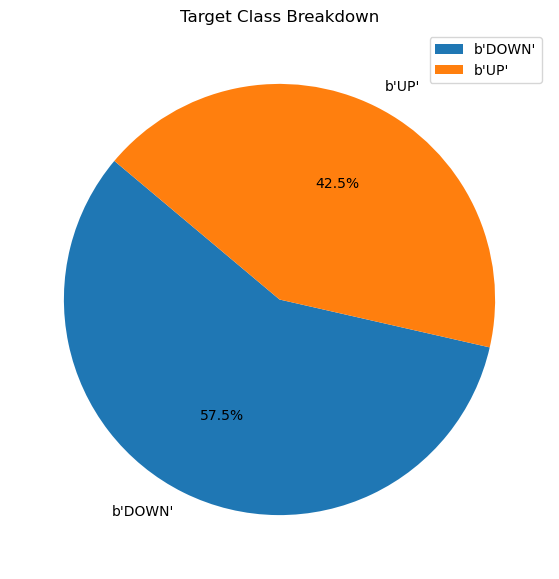

In [5]:
check_class_imbalance(df["class"])

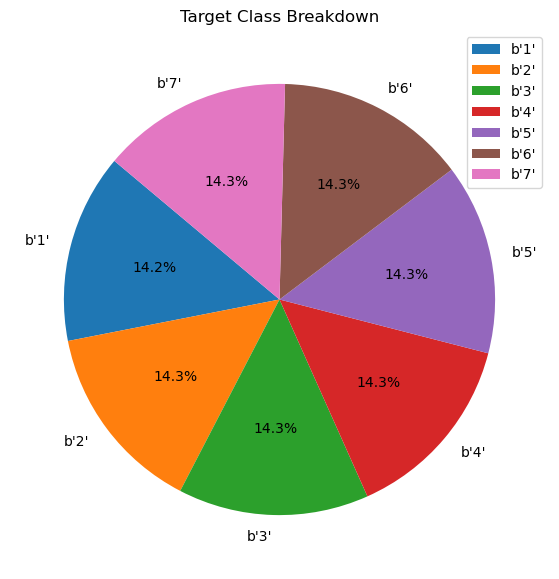

In [6]:
check_class_imbalance(df["day"])

In [7]:
df.describe()

,date,period,nswprice,nswdemand,vicprice,vicdemand,transfer
count,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000
mean,0.499080,0.500000,0.057868,0.425418,0.003467,0.422915,0.500526
std,0.340308,0.294756,0.039991,0.163323,0.010213,0.120965,0.153373
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.031934,0.250000,0.035127,0.309134,0.002277,0.372346,0.414912
50%,0.456329,0.500000,0.048652,0.443693,0.003467,0.422915,0.414912
75%,0.880547,0.750000,0.074336,0.536001,0.003467,0.469252,0.605702
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
df.dtypes

date         float64
day           object
period       float64
nswprice     float64
nswdemand    float64
vicprice     float64
vicdemand    float64
transfer     float64
class         object
dtype: object

In [13]:
numeric_columns = df.select_dtypes(exclude="object").drop("period", axis=1)
categorical_columns = df.select_dtypes(include="object")

# Heat Map

<AxesSubplot:>

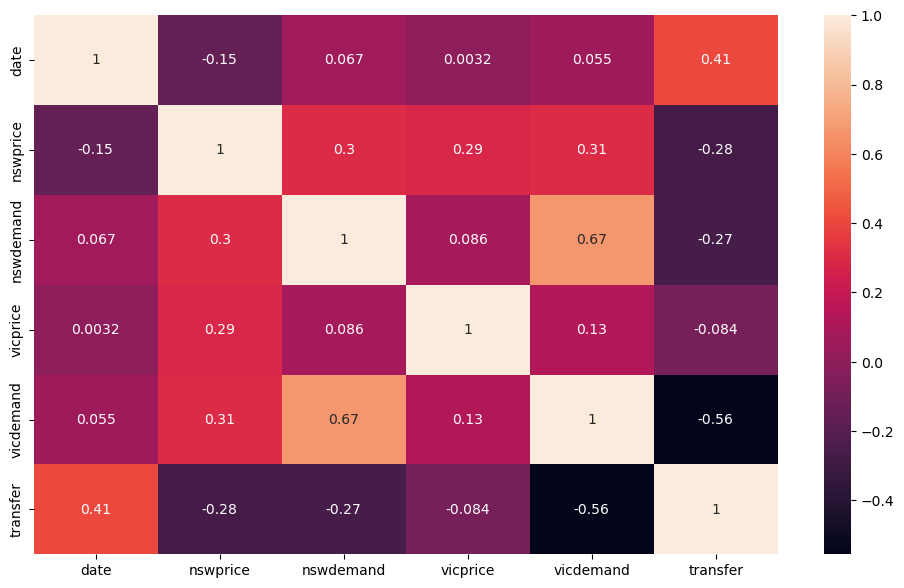

In [14]:
plt.figure(figsize=(12, 7))
corr = numeric_columns.corr()
sns.heatmap(data=corr, annot=True)

# Visuals

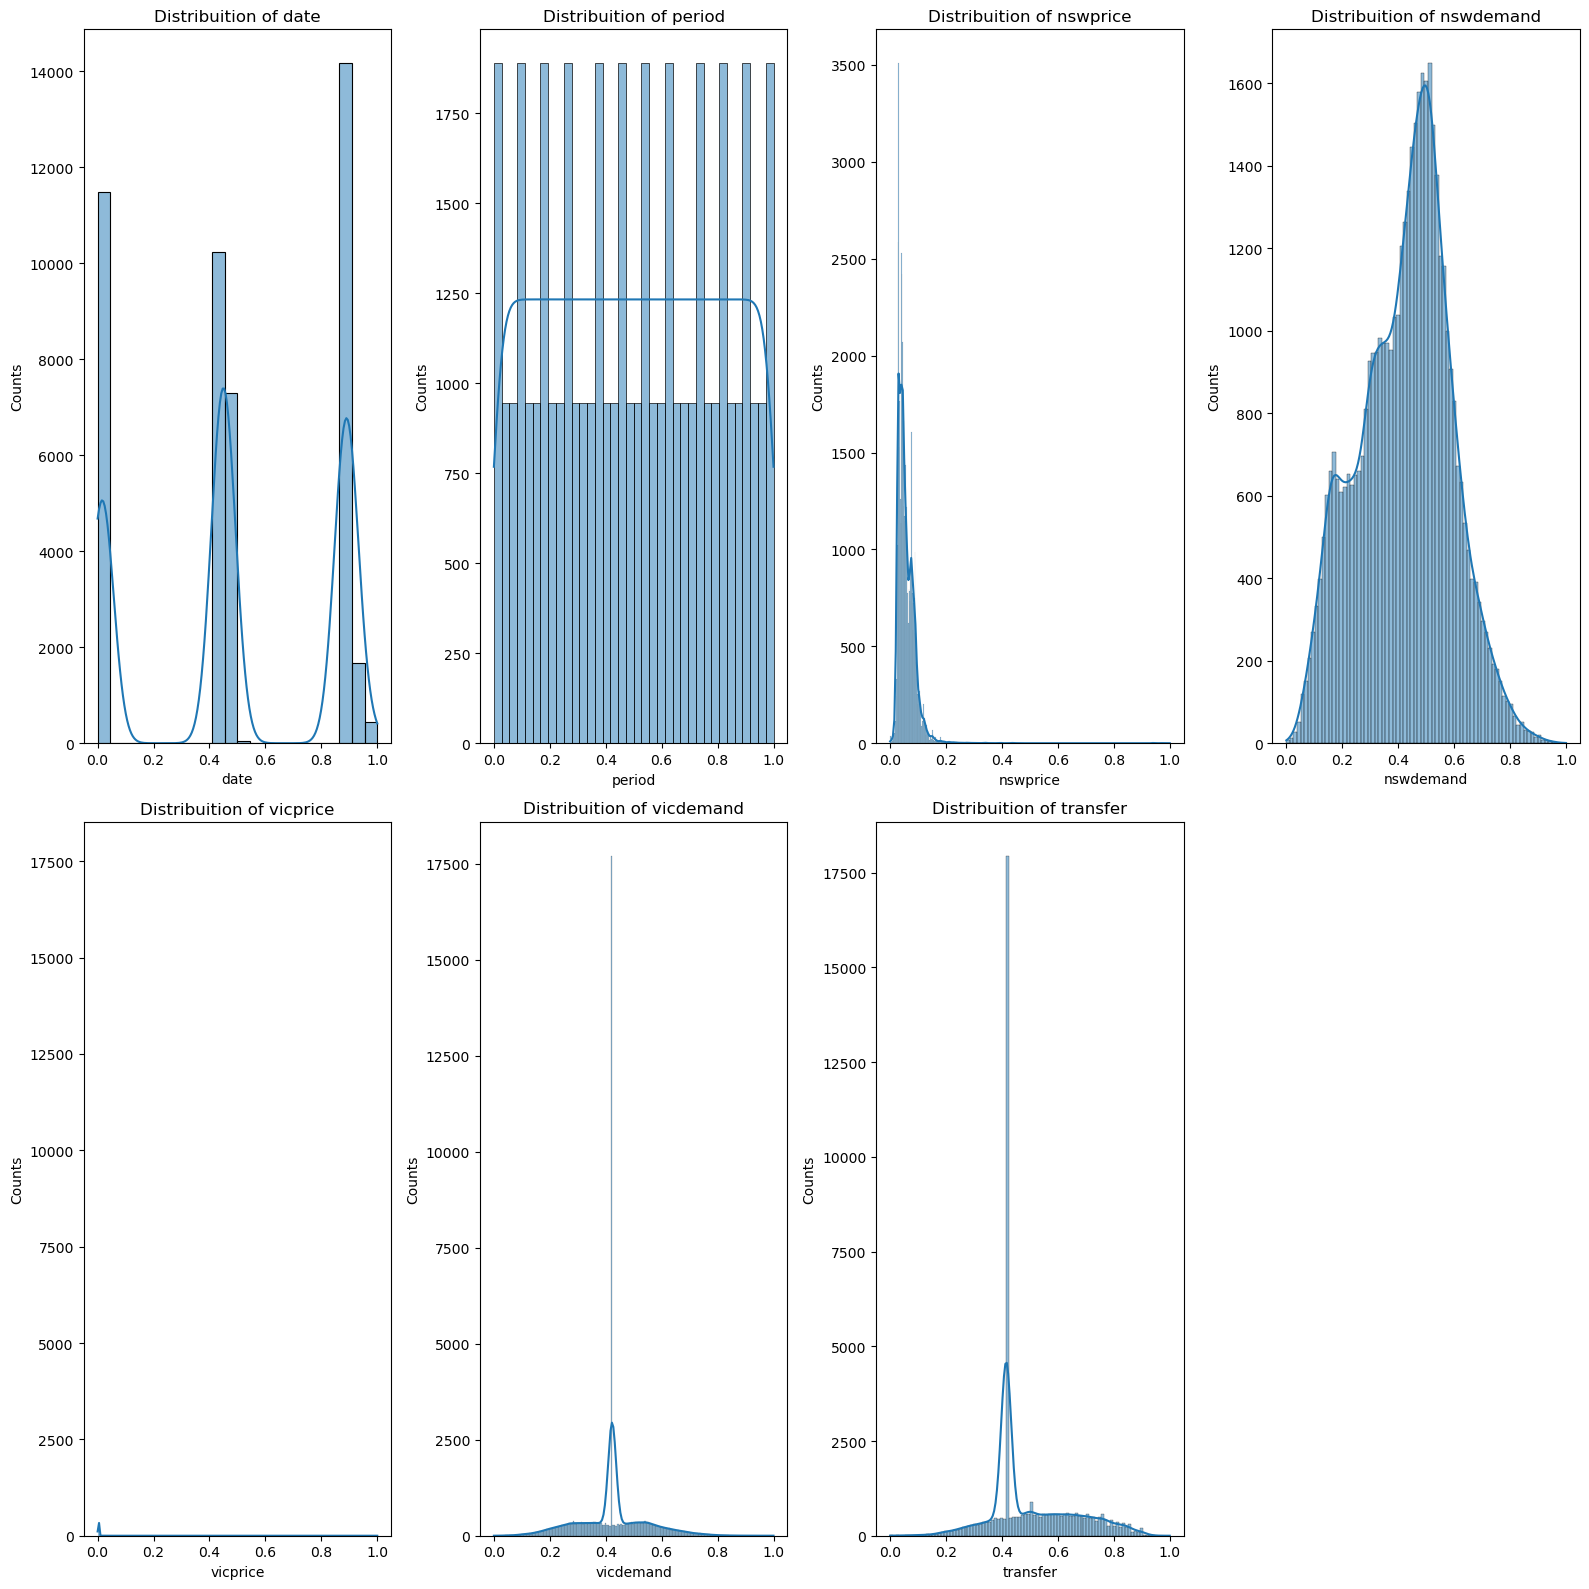

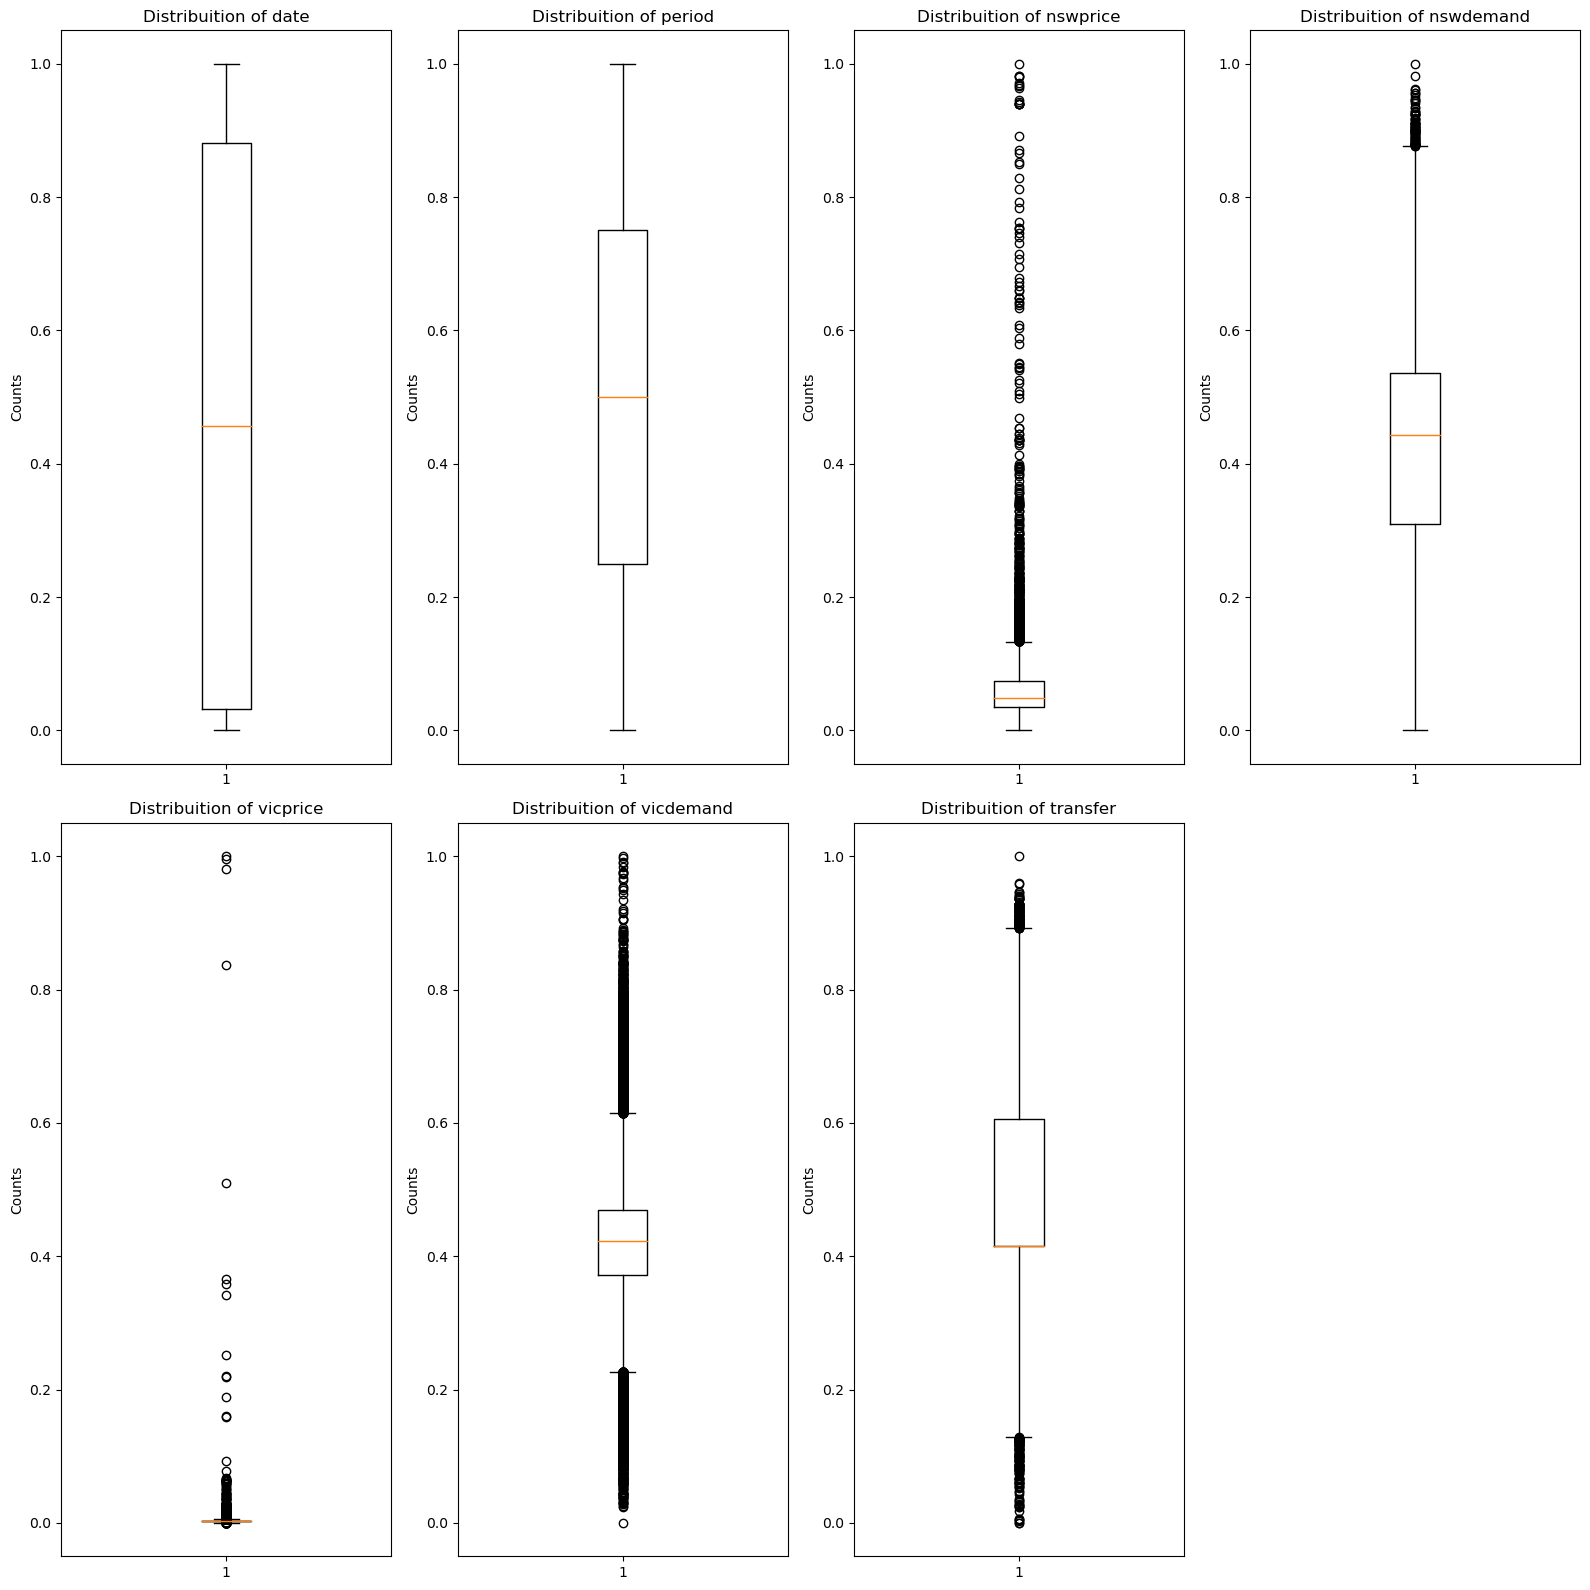

In [12]:
plot_distribution(numeric_columns, "hist")
plot_distribution(numeric_columns, "box")

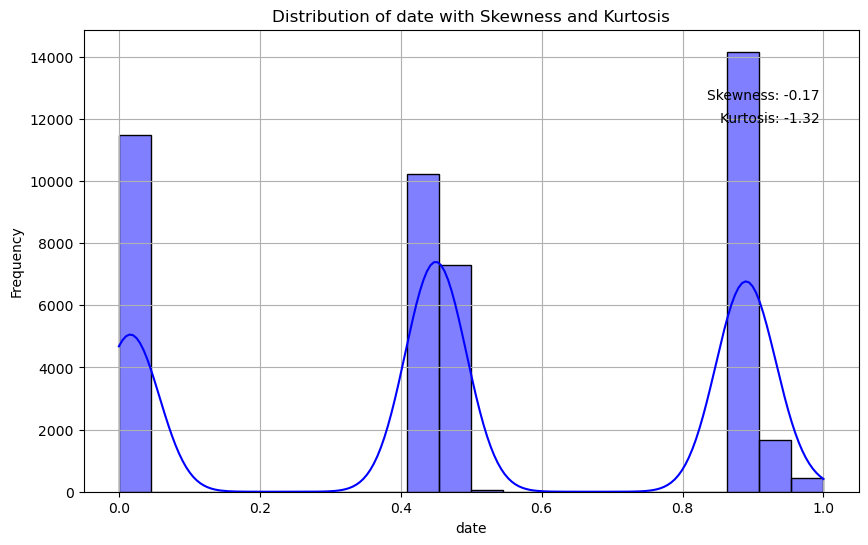

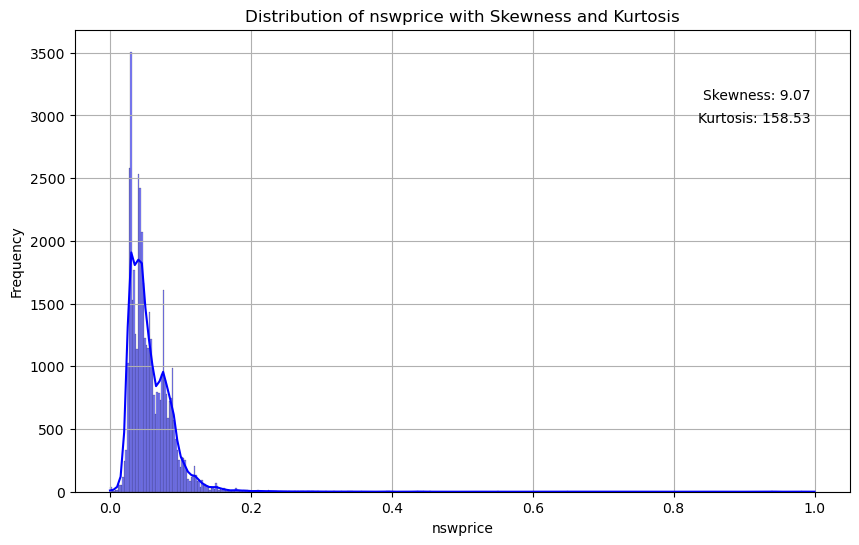

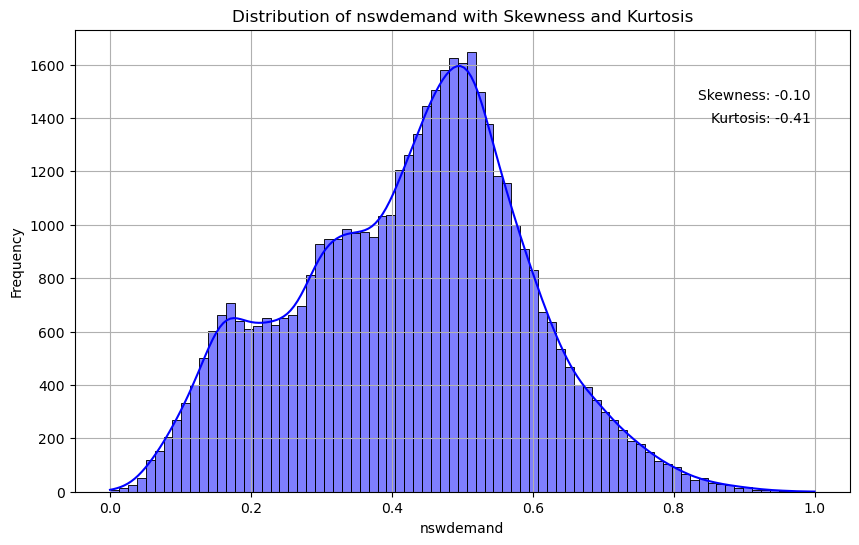

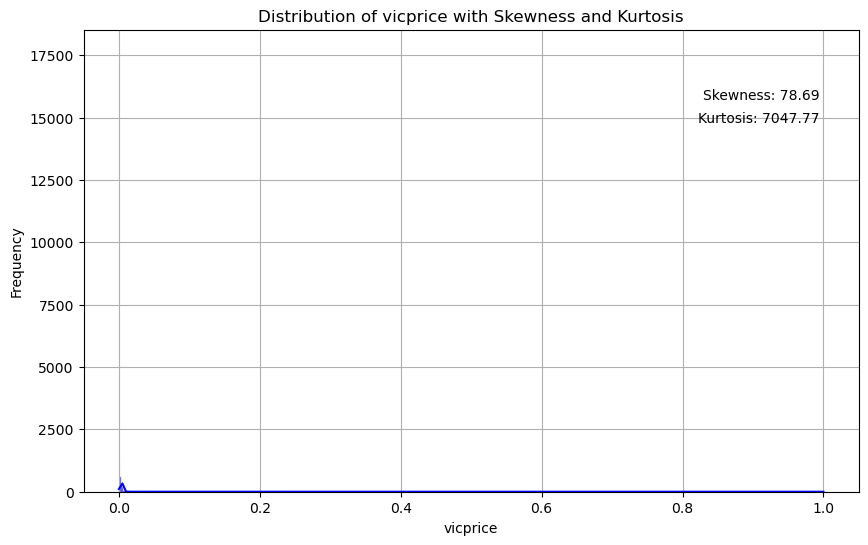

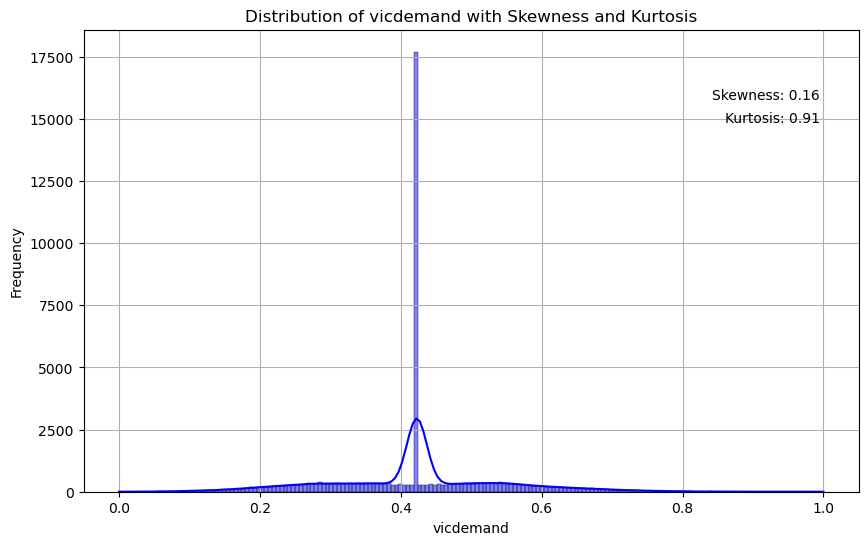

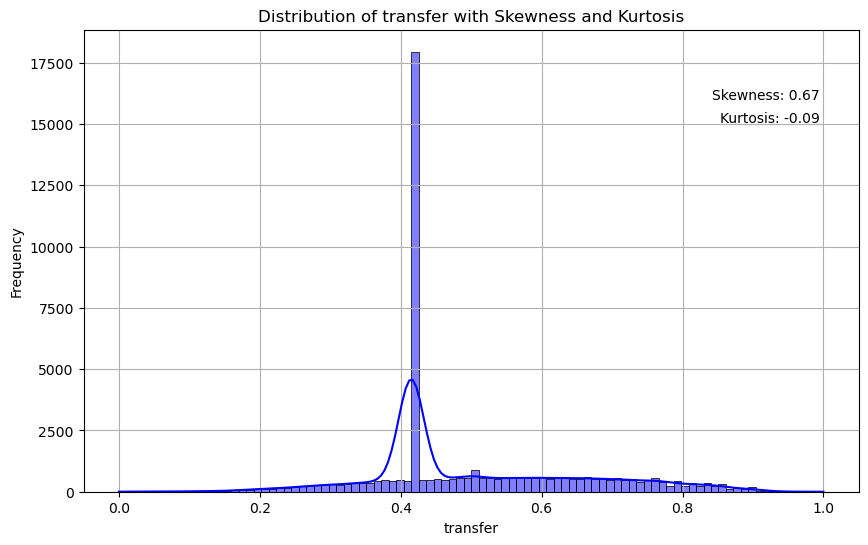

In [15]:
dist_plot(numeric_columns)

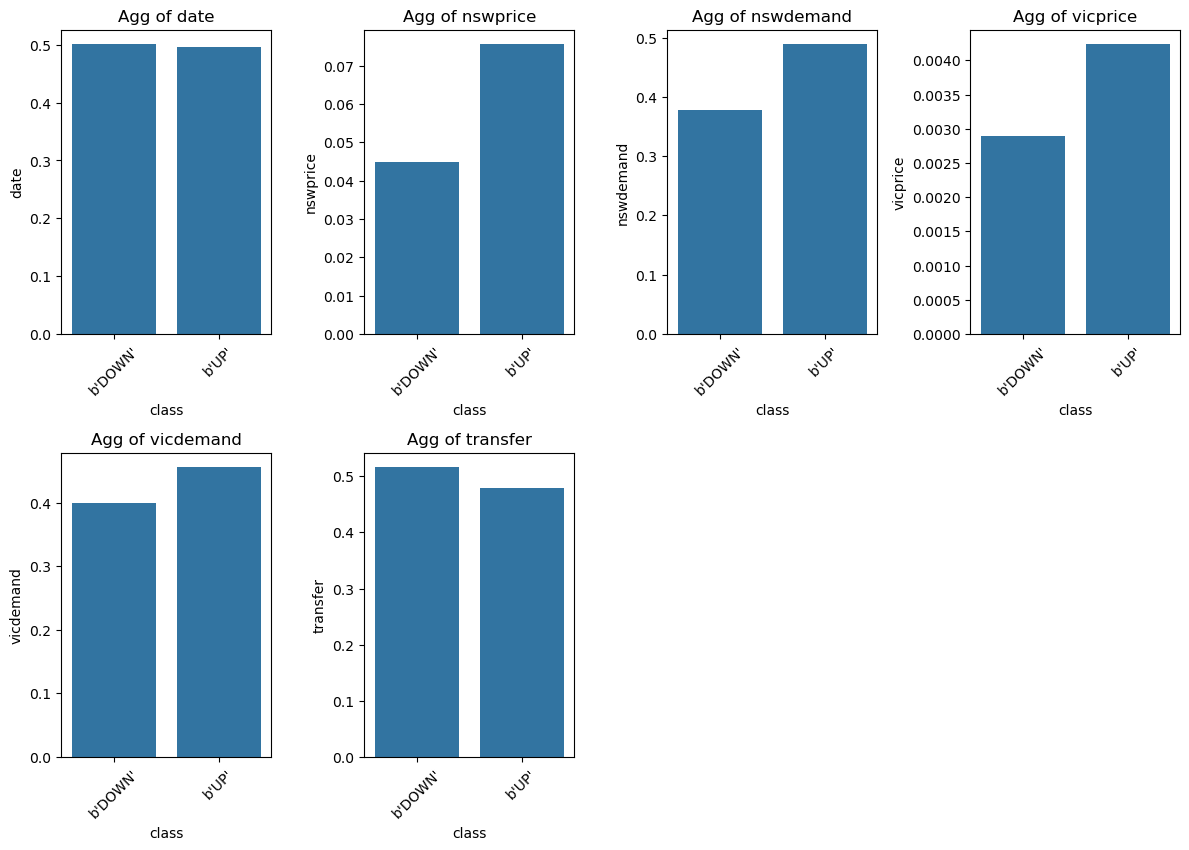

In [16]:
aggregate_dataset(df, numeric_columns.columns, "class", "mean")

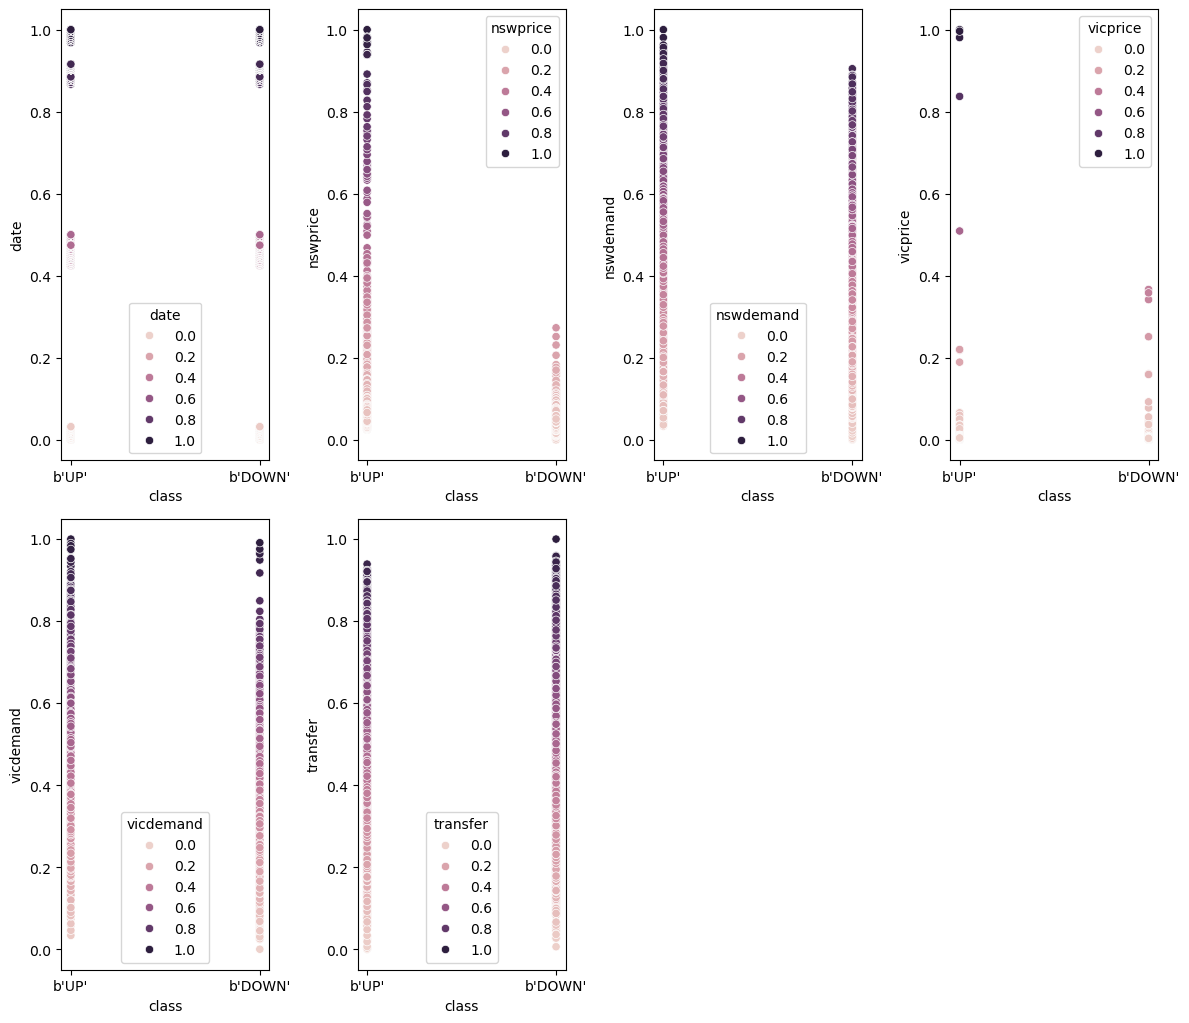

In [17]:
scatter_plot(df, numeric_columns.columns, "class")

# Separate Features

In [18]:
X = df.drop("class", axis=1)
y = df["class"]

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Preprocessor

In [19]:
categorical_columns.drop("class", axis=1, inplace=True)

preprocessor = create_column_transformer(categorical_columns.columns, numeric_columns.columns)
preprocessor

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('encoder', OneHotEncoder())]),
                                 Index(['day'], dtype='object')),
                                ('numeric',
                                 Pipeline(steps=[('scaler', RobustScaler()),
                                                 ('PowerTransformer',
                                                  PowerTransformer())]),
                                 Index(['date', 'nswprice', 'nswdemand', 'vicprice', 'vicdemand', 'transfer'], dtype='object'))])

# PCA Analysis

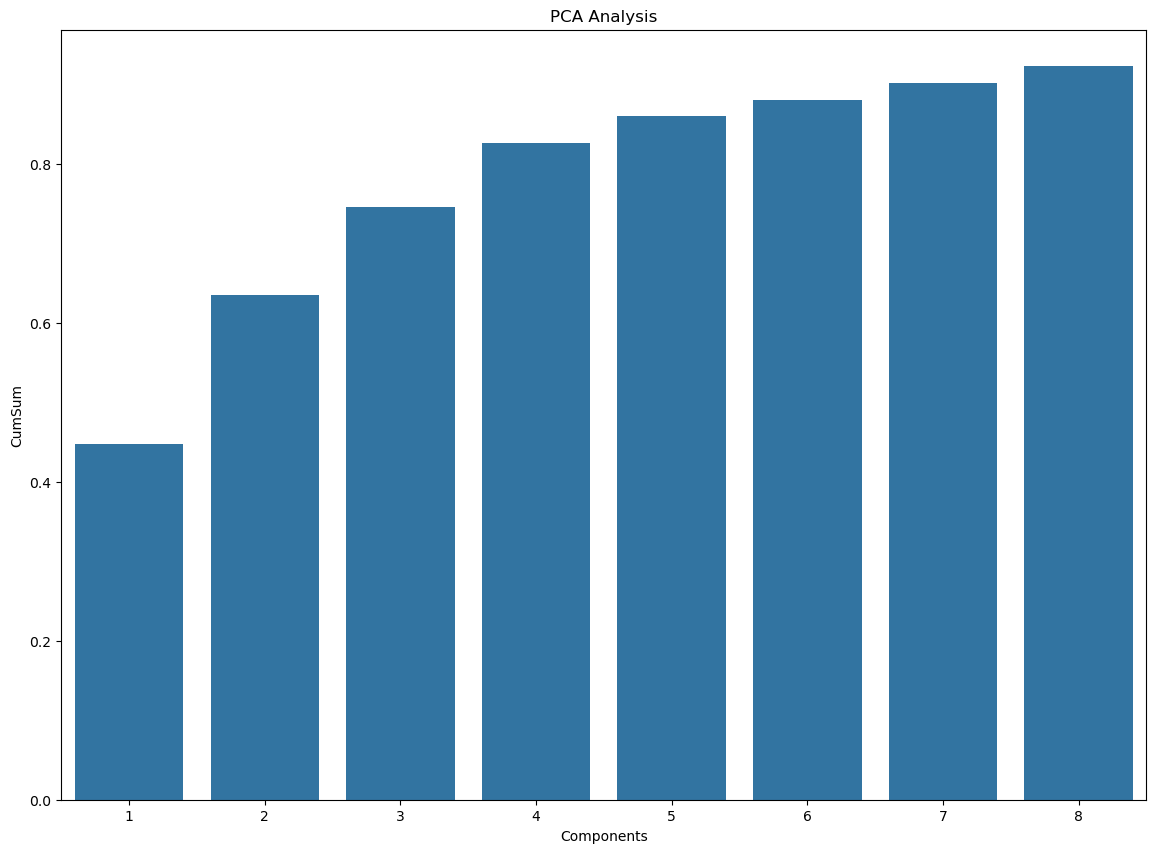

,Component,CumSum
0,1,0.447660
1,2,0.634926
2,3,0.746332
3,4,0.827158
4,5,0.860579
5,6,0.881489
6,7,0.902344
7,8,0.923195


In [20]:
pca_analysis(X, preprocessor)

In [21]:
acc_metric = make_scorer(accuracy_score, greater_is_better=True)
f1_metric = make_scorer(f1_score, greater_is_better=True, average="weighted")
precision_metric = make_scorer(precision_score, greater_is_better=True, average='weighted')
recall_metric = make_scorer(recall_score, greater_is_better=True, average='weighted')

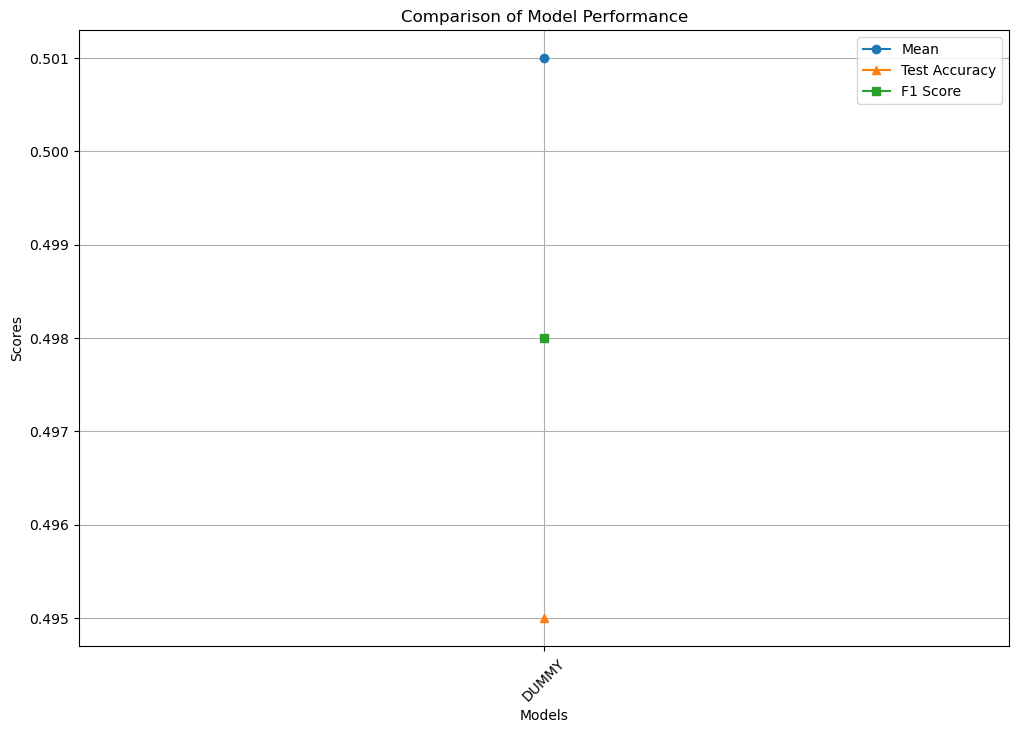

,Model,Mean,Var,STD,Test-Acc,recall-Score,precision-Score,F1-Score
0,DUMMY,0.501,0.0,0.007,0.495,0.495,0.507,0.498


In [24]:
model_name = ["DUMMY"]
models = grab_selected_models(model_name)
test_selected_models(preprocessor,model_name, models, X, y_encoded, acc_metric)

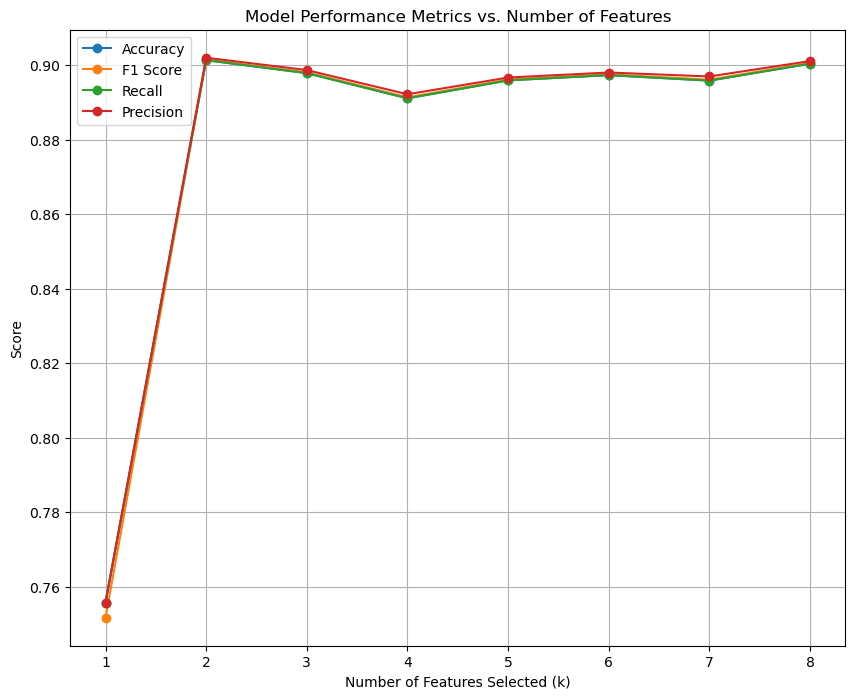

,Model,K,Selected Featured,acc_metric,f1_metric,recall,precision
0,XGB,1,nswprice,0.755768,0.751687,0.755768,0.755717
1,XGB,2,"date, nswprice",0.901291,0.901469,0.901291,0.901948
2,XGB,3,"date, nswprice, vicprice",0.897813,0.898024,0.897813,0.898634
3,XGB,4,"date, nswprice, nswdemand, vicprice",0.891059,0.891320,0.891059,0.892147
4,XGB,5,"date, nswprice, nswdemand, vicprice, vicdemand",0.895874,0.896077,0.895874,0.896634
5,XGB,6,"date, nswprice, nswdemand, vicprice, vicdemand...",0.897278,0.897469,0.897278,0.897978
6,XGB,7,"day_b'1', date, nswprice, nswdemand, vicprice,...",0.895807,0.896063,0.895807,0.896917
7,XGB,8,"day_b'1', day_b'4', date, nswprice, nswdemand,...",0.900354,0.900541,0.900354,0.901054


In [27]:
model_name = ["XGB"]
models = grab_selected_models(model_name)[0]
metric = mutual_info_classif
sample_model = SMOTE()
test_kbest_columns(preprocessor, X, y_encoded, sample_model, models, model_name[0], metric)

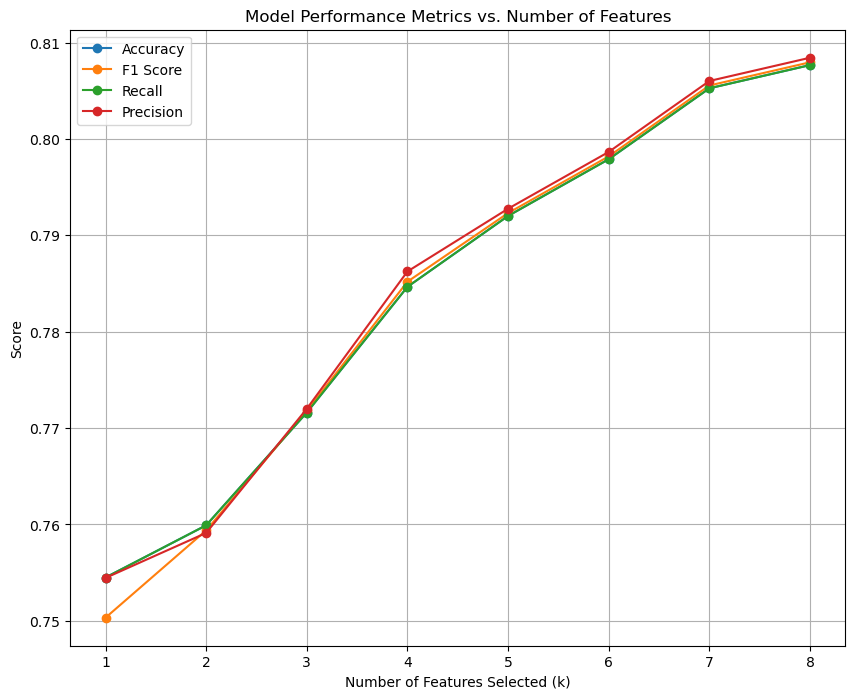

,Model,K,Selected Featured,acc_metric,f1_metric,recall,precision
0,XGB,1,nswprice,0.754497,0.750328,0.754497,0.754456
1,XGB,2,"nswprice, nswdemand",0.759914,0.759390,0.759914,0.759124
2,XGB,3,"nswprice, nswdemand, vicprice",0.771618,0.771793,0.771618,0.772009
3,XGB,4,"nswprice, nswdemand, vicprice, vicdemand",0.784659,0.785191,0.784659,0.786253
4,XGB,5,"nswprice, nswdemand, vicprice, vicdemand, tran...",0.792015,0.792311,0.792015,0.792764
5,XGB,6,"day_b'1', nswprice, nswdemand, vicprice, vicde...",0.797900,0.798195,0.797900,0.798656
6,XGB,7,"day_b'1', day_b'2', nswprice, nswdemand, vicpr...",0.805256,0.805548,0.805256,0.806016
7,XGB,8,"day_b'1', day_b'2', day_b'6', nswprice, nswdem...",0.807664,0.807955,0.807664,0.808428


In [28]:
metric = f_classif
test_kbest_columns(preprocessor, X, y_encoded, sample_model, models, model_name[0], metric)

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


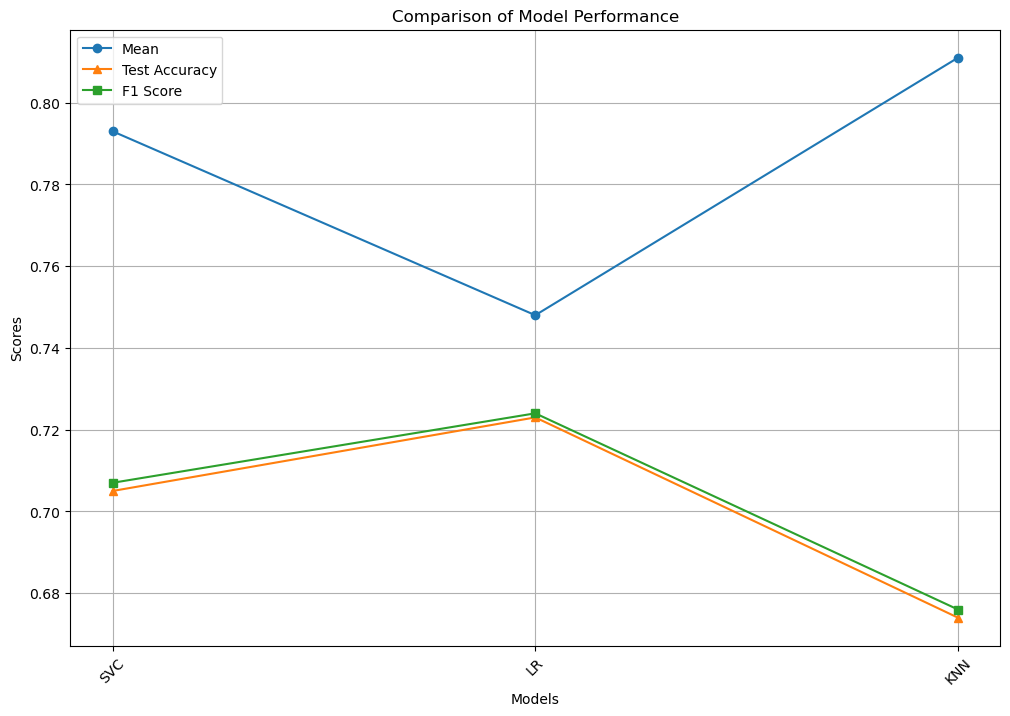

,Model,Mean,Var,STD,Test-Acc,recall-Score,precision-Score,F1-Score
2,KNN,0.811,0.0,0.006,0.674,0.674,0.680,0.676
0,SVC,0.793,0.0,0.006,0.705,0.705,0.714,0.707
1,LR,0.748,0.0,0.007,0.723,0.723,0.726,0.724


In [29]:
kbest = SelectKBest(score_func=mutual_info_classif, k=8)
model_names = ["SVC", "LR", "KNN"]
models = grab_selected_models(model_names)
test_selected_models(preprocessor,model_names, models, X, y_encoded, f1_metric, sample_model, kbest)

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: U

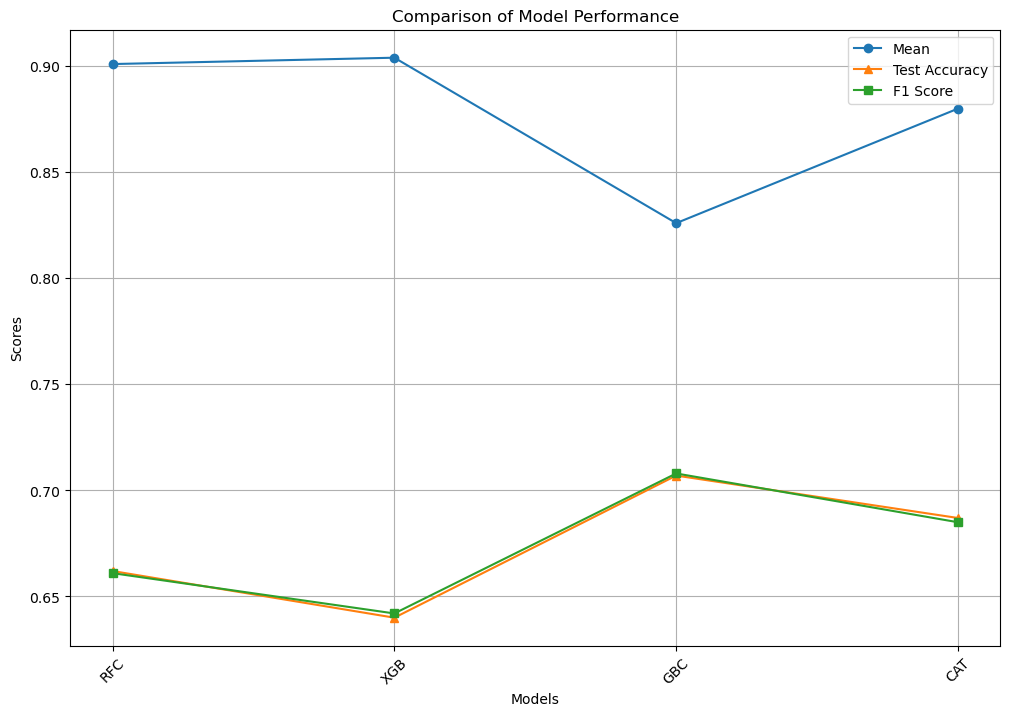

,Model,Mean,Var,STD,Test-Acc,recall-Score,precision-Score,F1-Score
1,XGB,0.904,0.0,0.004,0.640,0.640,0.654,0.642
0,RFC,0.901,0.0,0.004,0.662,0.662,0.660,0.661
3,CAT,0.880,0.0,0.005,0.687,0.687,0.685,0.685
2,GBC,0.826,0.0,0.006,0.707,0.707,0.709,0.708


In [30]:
kbest = SelectKBest(score_func=mutual_info_classif, k=8)
model_names = ["RFC", "XGB", "GBC", "CAT"]
models = grab_selected_models(model_names)
test_selected_models(preprocessor,model_names, models, X, y_encoded, f1_metric, sample_model, kbest)

In [32]:
params = {
    'GBC': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 4, 5],
        'model__min_samples_split': [2, 4],
        'model__min_samples_leaf': [1, 2]
    },
    'XGB': {
        'model__n_estimators': [100, 150, 200, 300],
        'model__learning_rate': [0.01, 0.02, 0.03, 0.05, 0.1],
        'model__max_depth': [3, 5, 7, 9],
        'model__subsample': [0.3, 0.4, 0.5, 0.6, 0.8, 1.0],
        'model__colsample_bytree': [0.6, 0.8, 1.0]
    },
    'RFC': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'SVC': {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf'],
        'model__gamma': ['scale', 'auto'],
        'model__degree': [2, 3, 4]
    },
    "CAT":{
    'model__iterations': [100, 500, 1000],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__depth': [4, 6, 10],
    'model__l2_leaf_reg': [1, 3, 5, 7],
    'model__border_count': [32, 64, 128],
    'model__loss_function': ['Logloss', 'CrossEntropy'],
    'model__boosting_type': ['Plain'],
    'model__bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS'],
    'model__grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide']
}
}

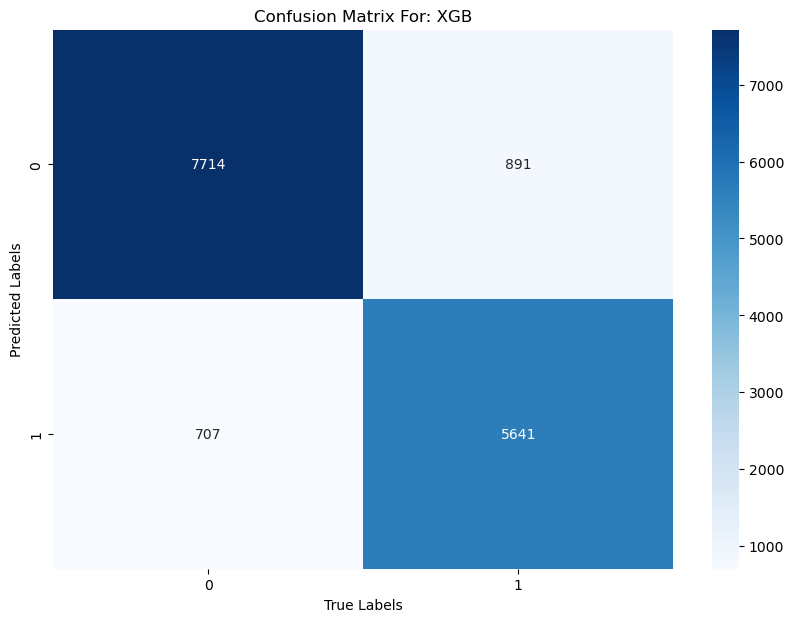

The Best Param: {'model__subsample': 0.3, 'model__n_estimators': 300, 'model__max_depth': 9, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.8}


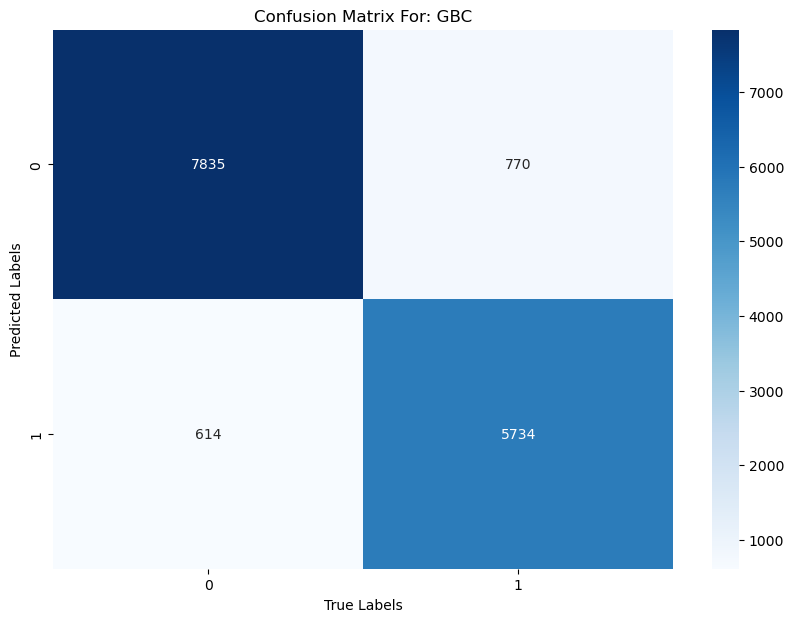

The Best Param: {'model__n_estimators': 300, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_depth': 5, 'model__learning_rate': 0.2}


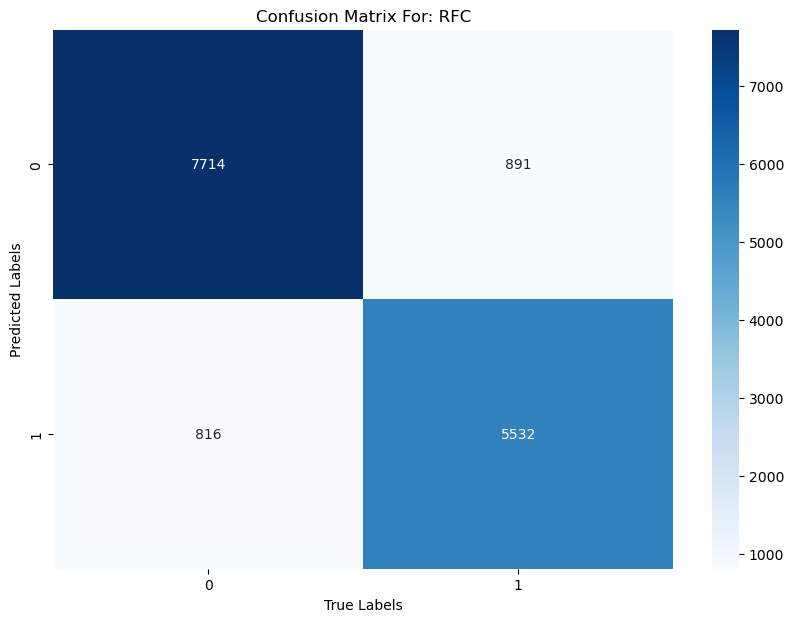

The Best Param: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_depth': None}


/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


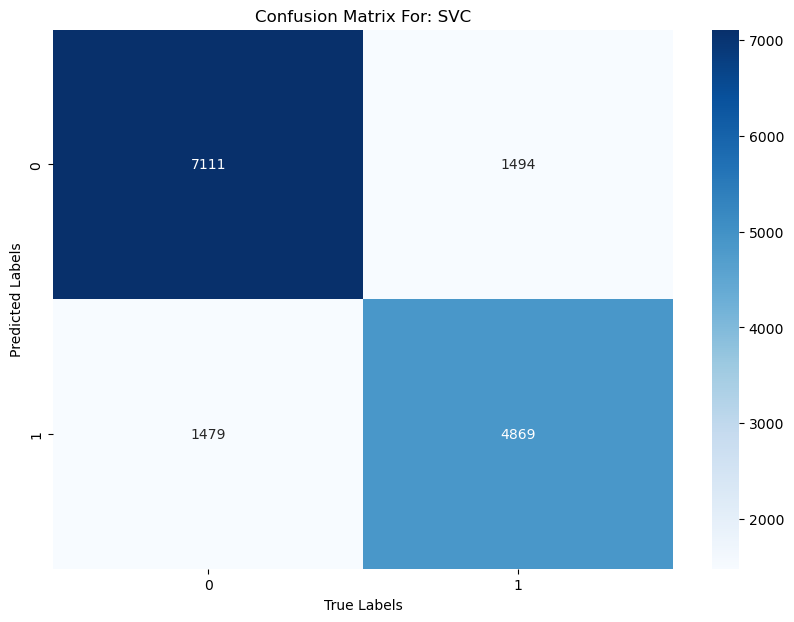

The Best Param: {'model__kernel': 'rbf', 'model__gamma': 'auto', 'model__degree': 2, 'model__C': 10}


/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


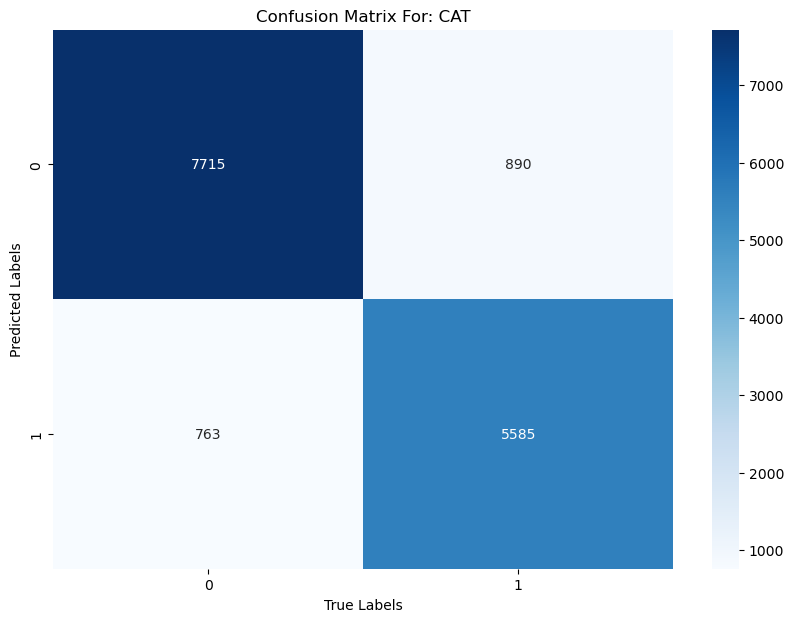

The Best Param: {'model__loss_function': 'Logloss', 'model__learning_rate': 0.1, 'model__l2_leaf_reg': 1, 'model__iterations': 1000, 'model__grow_policy': 'Depthwise', 'model__depth': 10, 'model__border_count': 128, 'model__bootstrap_type': 'Bayesian', 'model__boosting_type': 'Plain'}


,Model,Test-Acc,F1-Score,recall-Score,precision-Score
1,GBC,0.907443,0.907582,0.907443,0.907920
0,XGB,0.893132,0.893318,0.893132,0.893777
4,CAT,0.889454,0.889590,0.889454,0.889857
2,RFC,0.885842,0.885928,0.885842,0.886058
3,SVC,0.801177,0.801208,0.801177,0.801240


In [33]:
model_names = ["XGB", "GBC", "RFC", "SVC", "CAT"]
models = grab_selected_models(model_names)
performance_df, best_models = optimization_search(preprocessor, sample_model, model_names, models, X, y_encoded, RandomizedSearchCV, params, f1_metric, kbest)
performance_df.sort_values(by="F1-Score", ascending=False)

In [34]:
stack = [("XGB",best_models[0]), ("GBC", best_models[1]), ("RFC", best_models[2]), ("CAT", best_models[4])]

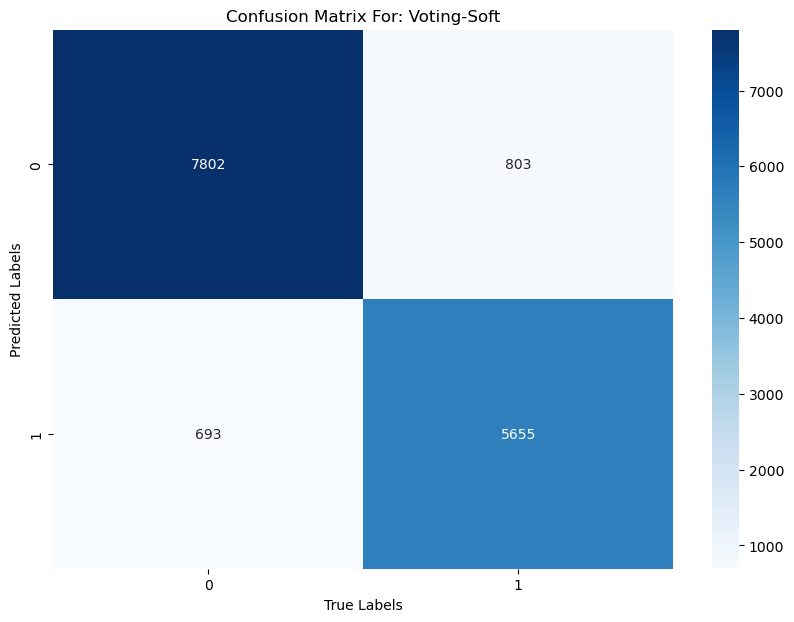

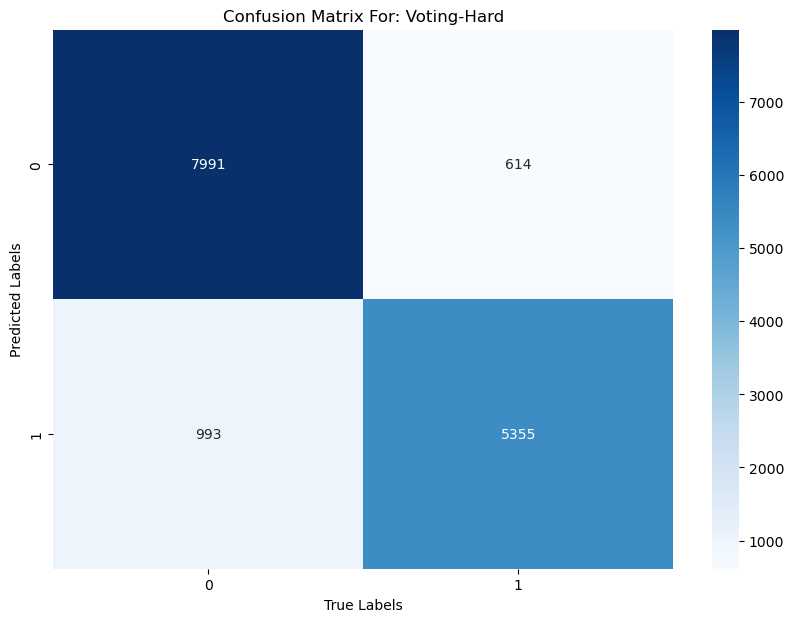

,Model,Test-Acc,F1-Score,recall-Score,precision-Score
0,Voting-Soft,0.899953,0.900061,0.899953,0.900268
1,Voting-Hard,0.892530,0.892034,0.892530,0.892724


In [35]:
voting_hard_clf = VotingClassifier(
  estimators=[
  stack[2],
  stack[0]
  ],
  voting="hard"
)

voting_soft_clf = VotingClassifier(
  estimators=[
  stack[2],
  stack[0]
  ],
  voting="soft"
)

models = [voting_soft_clf, voting_hard_clf]
model_names = ["Voting-Soft", "Voting-Hard"]

test_stacking_models(X, y_encoded, models, model_names)

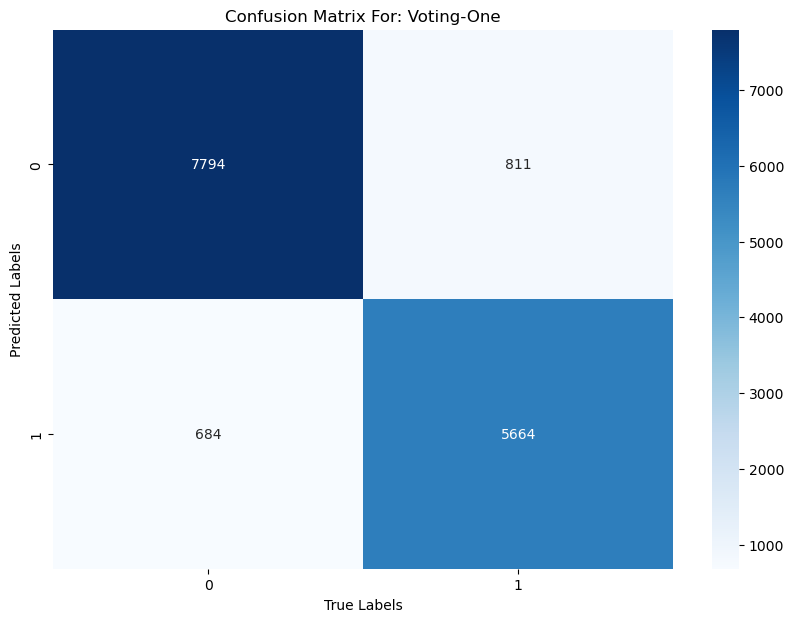

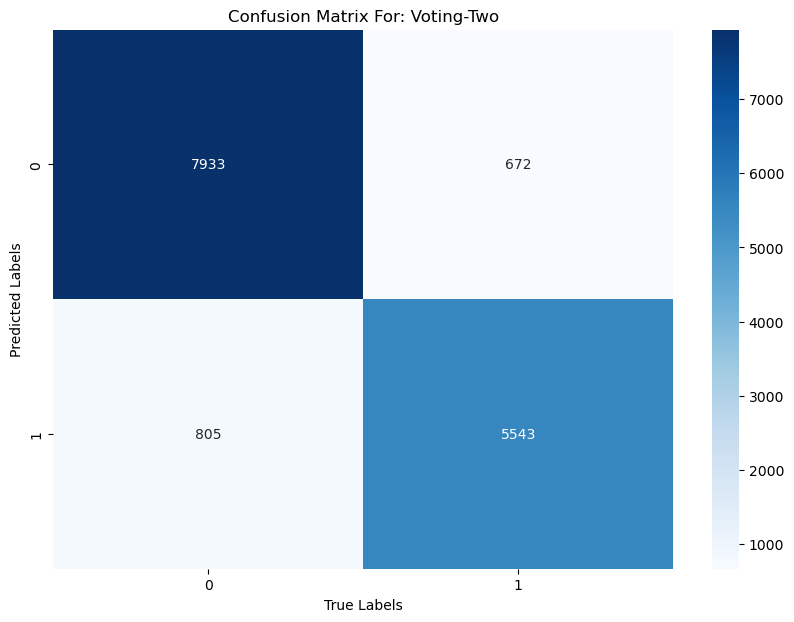

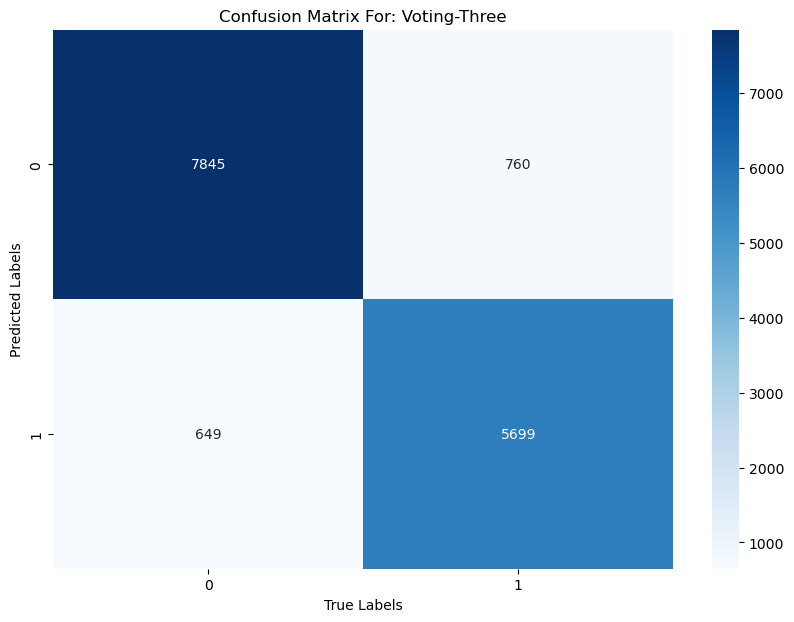

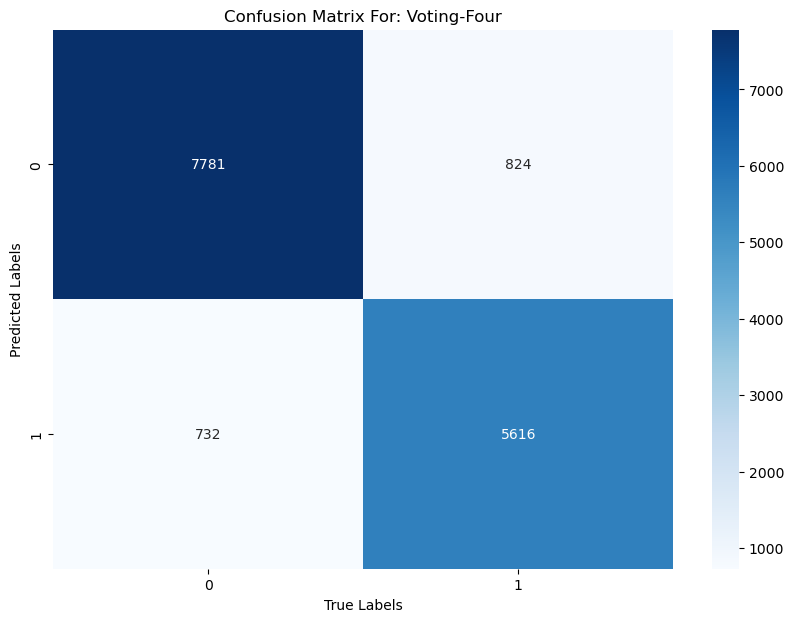

,Model,Test-Acc,F1-Score,recall-Score,precision-Score
2,Voting-Three,0.905771,0.905874,0.905771,0.906078
1,Voting-Two,0.901224,0.901080,0.901224,0.901082
0,Voting-One,0.900020,0.900144,0.900020,0.900399
3,Voting-Four,0.895941,0.896035,0.895941,0.896199


In [36]:
voting_one_clf = VotingClassifier(
  estimators=[
  stack[2],
  stack[0],
  stack[3]
  ],
  voting="hard"
)

voting_two_clf = VotingClassifier(
  estimators=[
  stack[2],
  stack[0],
  stack[3],
  stack[1]
  ],
  voting="hard"
)

voting_three_clf = VotingClassifier(
  estimators=[
  stack[2],
  stack[0],
  stack[3],
  stack[1]
  ],
  voting="soft"
)

voting_four_clf = VotingClassifier(
  estimators=[
  stack[2],
  stack[0],
  stack[3],
  ],
  voting="soft"
)

models = [voting_one_clf, voting_two_clf, voting_three_clf, voting_four_clf]
model_names = ["Voting-One", "Voting-Two", "Voting-Three", "Voting-Four"]

test_stacking_models(X, y_encoded, models, model_names)

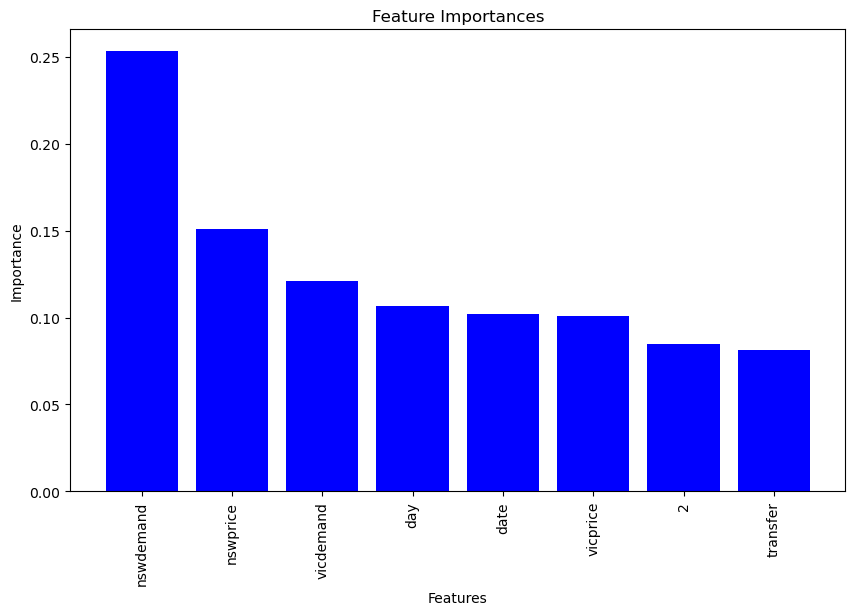

In [37]:
xgb_clf = stack[0][1]
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.33, random_state=42)

xgb_clf.fit(X_train, y_train)
transformed_features = get_feature_names(xgb_clf.named_steps['preprocessor'])
selected_mask = xgb_clf.named_steps['Feature Selection'].get_support()

feature_importances = xgb_clf.named_steps['model'].feature_importances_
all_features = [feature for is_selected, feature in zip(xgb_clf.named_steps['Feature Selection'].get_support(), transformed_features)]


selected_features = [feature for feature, selected in zip(all_features, selected_mask) if selected]
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(feature_importances)), feature_importances[indices], color='b')
plt.xticks(range(len(feature_importances)), [all_features[i] for i in indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()